<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/ISOTIPO-Color.jpg" title="Title text" width="20%" />

<hr style="height:2px;border:none"/>
<H1 align='center'> Pregunta de Investigación </H1>
<H5 align='center'> Es posible obtener pronósticos a múltiples pasos sobre una serie de tiempo usando recursivamente una red entrenada para predecir sólo el siguiente valor. </H5>

<H3> INF-395 Redes Neuronales y Deep Learning </H3>
<H3> Autores: Francisco Andrades | Lucas Díaz</H3>

Lenguaje: Python

Temas:

    - Redes Neuronales Recurrentes.
    - Modelos Generativos.
    - Autoencoders.
    - Modelos Especiales.

Video Explicativo: https://youtu.be/KqIuNZ4qrvY

<hr style="height:2px;border:none"/>

In [1]:
# recursive multi-step forecast with linear algorithms
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

In [3]:
import pandas as pd
import numpy as np

## **Pregunta de Investigación**


Hipótesis:  Es posible obtener pronósticos a múltiples pasos sobre una serie de tiempo usando recursivamente una red entrenada para predecir sólo el siguiente valor.

# Demostración:

> Se demostrará la hipótesis evidenciando una instancia donde el pronóstico resulta mejor que la media para una cantidad no despreciable de steps.

# Metodología

* Predicción de n días con una RNN.
    * Retroalimentando con predicción.
* Predicción de n días con la media.
* Establecer comparación entre ambos métodos.

# Dataset 1

* https://machinelearningmastery.com/multi-step-time-series-forecasting-with-machine-learning-models-for-household-electricity-consumption/

* https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

* Dataset

https://drive.google.com/drive/folders/1RsnxLwczJngVlQQp7nlIW2XTFfNSuhT4

In [4]:
dataset = pd.read_csv('household_power_consumption_days.csv', 
                      header=0, 
                      infer_datetime_format=True, 
                      parse_dates=['datetime'], 
                      index_col=['datetime']
                      )

In [5]:
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

train, test = split_dataset(dataset.values)
print(train.shape, test.shape)

(159, 7, 8) (46, 7, 8)


In [6]:
def build_model():
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(7, 1)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	return model

In [7]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# prepare a list of ml models
def get_models(models=dict()):
    # linear models
    models['rnn'] = build_model()
    print('Defined %d models' % len(models))
    return models
 
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# make a recursive multi-step forecast
def forecast(model, input_x, n_input):
    yhat_sequence = list()
    input_data = [x for x in input_x]
    #print(array(input_data).shape)
    for j in range(7):
        # prepare the input data
        X = array(input_data[-n_input:]).reshape(1, n_input)
        X = X.reshape(1, 7, 1)
        # make a one-step forecast
        yhat = model.predict(X)[0]
        # add to the result
        yhat_sequence.append(yhat)
        # add the prediction to the input
        input_data.append(yhat)
    return yhat_sequence
 
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 0] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series
 
# convert history into inputs and outputs
def to_supervised2(train, n_input, n_out=7):
    # flatten data
    train = array(train)
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

global scaler
# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
    # prepare data
    global scaler
    train_x, train_y = to_supervised2(history, n_input)
    pipeline = make_pipeline(model)
    scaler_datos = StandardScaler()
    scaler = StandardScaler()
    train_x[:,:,0] = scaler_datos.fit_transform(train_x[:,:,0])
    train_y = scaler.fit_transform(train_y)
    pipeline.fit(train_x, train_y)
    yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
    return scaler.inverse_transform(np.array(yhat_sequence).T).T
 
# evaluate a single model
def evaluate_model(model, train, test, n_input):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = sklearn_predict(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        var = array([yhat_sequence, ]*8)
        history.append(var.squeeze().T)
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions
 
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)

n_input=7
model = build_model()
score, scores, predicted = evaluate_model(model, train, test, n_input)

45/45 [==============================] - 1s 16ms/step - loss: 0.5860


In [8]:
media = np.mean(test[:, :, 0].flatten())
mediapor322 = np.full(322, media)

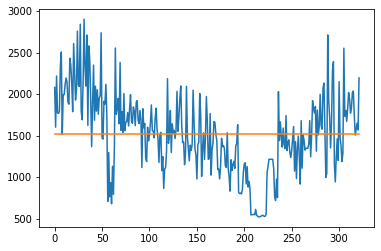

In [9]:
pyplot.plot(test[:, :, 0].flatten())
pyplot.plot(mediapor322)
pyplot.show()

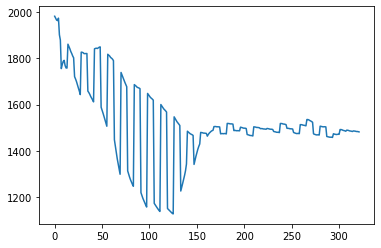

In [10]:
pyplot.plot(predicted.reshape(46, 7).flatten())

In [11]:
minuendo = (test[:,:,0].flatten() - predicted.reshape(46,7).flatten())**2
sustraendo = (test[:,:,0].flatten() - mediapor322)**2

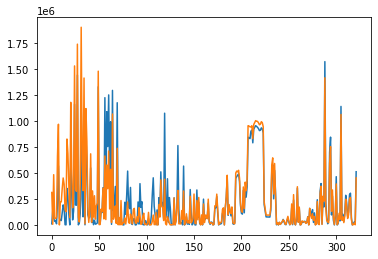

In [12]:
pyplot.plot(minuendo)
pyplot.plot(sustraendo)
pyplot.show()

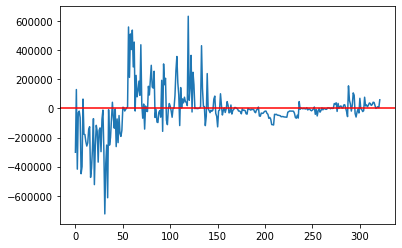

In [13]:
diferencia = minuendo - sustraendo
pyplot.plot(diferencia)
pyplot.axhline(y = 0, color = 'r', linestyle = '-')
pyplot.show()

## Dataset 2

* https://www.relataly.com/multi-step-time-series-forecasting-a-step-by-step-guide/275/

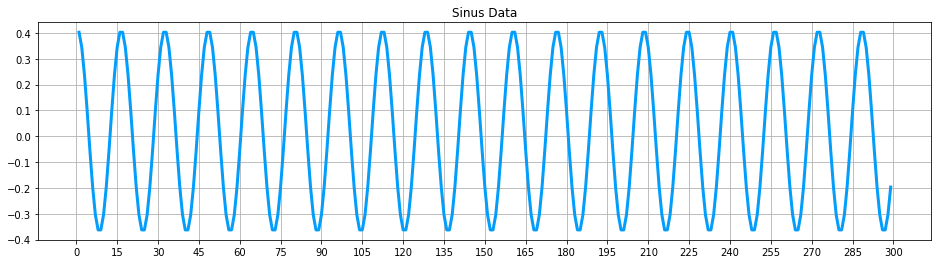

In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation
from sklearn.preprocessing import StandardScaler

# Creating the sample sinus curve dataset
steps = 300
gradient = 0.02
list_a = []
for i in range(0, steps, 1):
    y = round(gradient * i + math.sin(math.pi * 0.125 * i), 5)
    list_a.append(y)
df = pd.DataFrame({"valid": list_a}, columns=["valid"])
df_aux = df.copy()
df = df.diff().dropna()
# Visualizing the data
fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title("Sinus Data")
plt.plot(df[["valid"]], color="#039dfc", linewidth=3.0)
plt.grid()
plt.show()

In [15]:
# Get the number of rows in the data
nrows = df.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(df)
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 20

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_unscaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_unscaled[0:train_data_len, :]
test_data = np_data_unscaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

In [16]:
# Configure the neural network model
epochs = 12; batch_size = 1;

n_neurons = x_train.shape[1] * x_train.shape[2]
model = Sequential()
model.add(LSTM(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/12
220/220 [==============================] - 3s 3ms/step - loss: 0.3820
Epoch 2/12
220/220 [==============================] - 1s 3ms/step - loss: 6.8638e-04
Epoch 3/12
220/220 [==============================] - 1s 3ms/step - loss: 5.5222e-04
Epoch 4/12
220/220 [==============================] - 1s 3ms/step - loss: 3.9938e-04
Epoch 5/12
220/220 [==============================] - 1s 3ms/step - loss: 3.6654e-04
Epoch 6/12
220/220 [==============================] - 1s 3ms/step - loss: 1.8541e-04
Epoch 7/12
220/220 [==============================] - 1s 3ms/step - loss: 1.1495e-04
Epoch 8/12
220/220 [==============================] - 1s 3ms/step - loss: 7.4635e-05
Epoch 9/12
220/220 [==============================] - 1s 3ms/step - loss: 4.2568e-05
Epoch 10/12
220/220 [==============================] - 1s 3ms/step - loss: 5.8067e-05
Epoch 11/12
220/220 [==============================] - 1s 3ms/step - loss: 1.9249e-05
Epoch 12/12
220/220 [==============================] - 1s 3ms/step 

In [17]:
# Reshape the data, so that we get an array with multiple test datasets
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

y_test = scaler.inverse_transform(y_test)
# Get the root mean squarred error (RMSE) and the meadian error (ME)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
me = np.median(y_test - predictions)
print("me: " + str(round(me, 4)) + ", rmse: " + str(round(rmse, 4)))

me: -0.0003, rmse: 0.0002


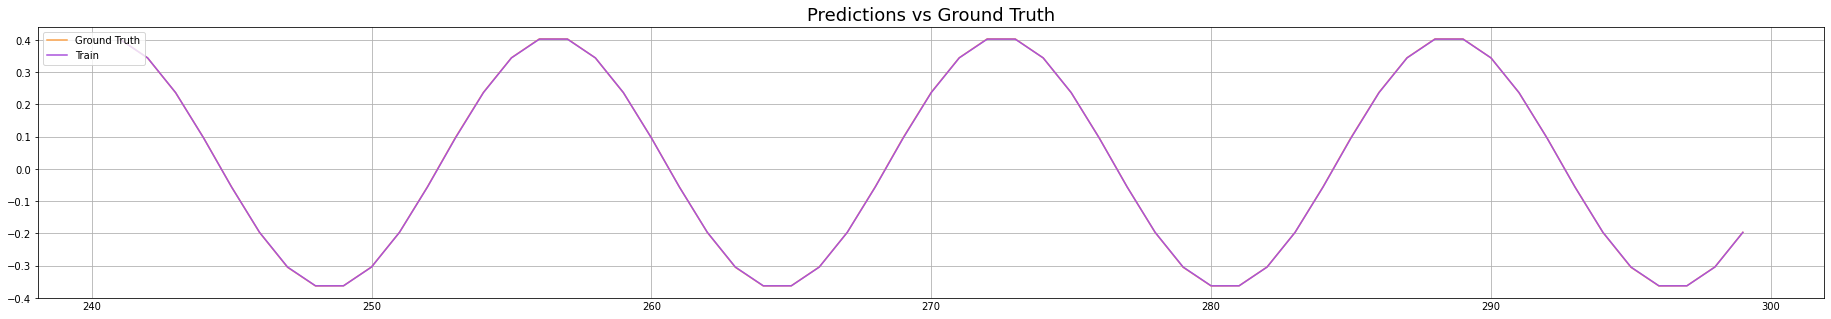

In [18]:
# Visualize the data
train = df[:train_data_len]
valid = df[train_data_len:]
valid.insert(1, "Predictions", predictions, True)
fig, ax1 = plt.subplots(figsize=(32, 5), sharex=True)
yt = train[["valid"]]
yv = valid[["valid", "Predictions"]]
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("Predictions vs Ground Truth", fontsize=18)
plt.plot(yv["Predictions"], color="#F9A048")
plt.plot(yv["valid"], color="#A951DC")
plt.legend(["Ground Truth", "Train"], loc="upper left")
plt.grid()
plt.show()

In [19]:
rolling_forecast_range = 60
# Making a Multi-Step Prediction
new_df = df.filter(["valid"])
new_df = new_df.iloc[:-60]
for i in range(0, rolling_forecast_range):
    last_values = new_df[-20:].values
    last_values_scaled = scaler.transform(last_values)
    X_input = []
    X_input.append(last_values_scaled)
    X_input = np.array(X_input)
    pred_value = model.predict(X_input)
    pred_value_unscaled = scaler.inverse_transform(pred_value)
    next_index = new_df.iloc[[-1]].index.values + 1
    new_df = new_df.append(pd.DataFrame({"valid": pred_value_unscaled[0, 0]}, index=next_index))
    new_df_length = new_df.size

In [20]:
forecast = new_df.iloc[-rolling_forecast_range:]#.values

In [21]:
media_df = df[:-rolling_forecast_range].mean()[0]
media_df

0.018398828451882843

In [22]:
# reconstruir la serie
lista = [df_aux.iloc[-61].values[0]]
lista_media = [df_aux.iloc[-61].values[0]]
for i in range(rolling_forecast_range):
    lista.append(lista[-1] + forecast.values[i][0])
    lista_media.append(lista_media[-1] + media_df)
lista = lista[1:]
lista_media = lista_media[1:]

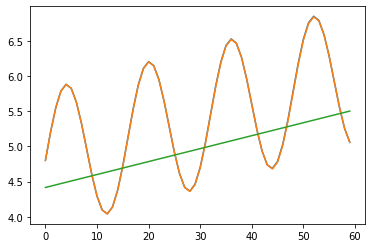

In [23]:
plt.plot(lista)
plt.plot(df_aux.values[-rolling_forecast_range:])
plt.plot(lista_media)
plt.show()

In [24]:
df2 = df_aux.copy()
df2.iloc[-rolling_forecast_range:] = np.array(lista).reshape(rolling_forecast_range, 1)

df3 = df_aux.copy()
df3.iloc[-rolling_forecast_range:] = np.array(lista_media).reshape(rolling_forecast_range, 1)

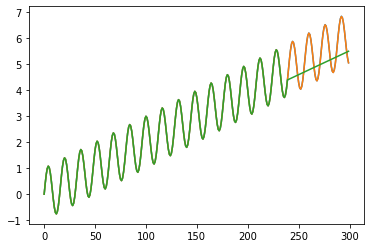

In [25]:
plt.plot(df2)
plt.plot(df_aux)
plt.plot(df3)
plt.show()

In [26]:
error_rnn = (df_aux.values[-rolling_forecast_range:].reshape(-1) - np.array(lista).reshape(-1))**2
error_media = (df_aux.values[-rolling_forecast_range:].reshape(-1) - np.array(lista_media).reshape(-1))**2

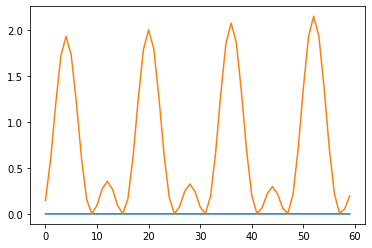

In [27]:
plt.plot(error_rnn)
plt.plot(error_media)
plt.show()

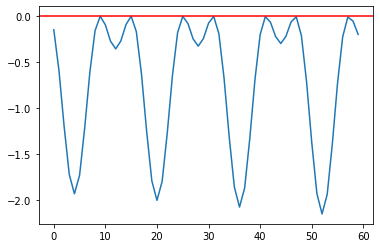

In [28]:
plt.plot(error_rnn - error_media)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.show()

# Conclusiones

Volviendo a la pregunta de investigación: "_es posible obtener pronósticos a múltiples pasos sobre una serie de tiempo usando recursivamente una red entrenada para predecir sólo el siguiente valor_".

* Sí, es posible.
* Una red recurrente entrenada de forma recursiva es capaz de hacer una predicción mejor que la media para los primeros n _time steps_. La cantidad n es específica al problema.
* Debido al cono de incertidumbre, mientras más distante una predicción, mayor será el error acumulado.
* Puede ocurrir que la red decida converger sus predicciones hacia la media.
* Existen series de tiempo (sencillas) en que predecir recursivamente pareciera acumular un error despreciable.